In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
df = pd.read_csv("ICBHI 2017/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv")
df.head()

,101,URTI
0,102,Healthy
1,103,Asthma
2,104,COPD
3,105,URTI
4,106,COPD


In [3]:
df['URTI'].unique()

array(['Healthy', 'Asthma', 'COPD', 'URTI', 'LRTI', 'Bronchiectasis',
       'Pneumonia', 'Bronchiolitis'], dtype=object)

In [4]:
sr_no = {'101':'URTI'}
for i, j in zip(df['101'].unique(), df['URTI']):
    sr_no[str(i)] = j

In [5]:
sr_no.keys()

dict_keys(['101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226'])

In [6]:
import os
sound_files = os.listdir('Mel Spectrogram/Original')

In [7]:
req_file_names = []

for i in sound_files:
      req_file_names.append([i])

In [8]:
labels = []
for i in range(len(req_file_names)):
    req_file_names[i].append(sr_no[req_file_names[i][0][:3]])
    labels.append(sr_no[req_file_names[i][0][:3]])

In [9]:
labels *= 3

In [10]:
x = []

for i in req_file_names:
    img = cv2.imread('Mel Spectrogram/Time Stretch/'+i[0])
    img = cv2.resize(img, (350, 350))
    x.append(img)

for i in req_file_names:
    img = cv2.imread('Mel Spectrogram/Pitch Shift/'+i[0])
    img = cv2.resize(img, (350, 350))
    x.append(img)
    
for i in req_file_names:
    img = cv2.imread('Mel Spectrogram/Audio Shift/'+i[0])
    img = cv2.resize(img, (350, 350))
    x.append(img)

# x = np.array(x)
# print(x.shape)

In [11]:
x_new = []
y = []

for i in range(len(labels)):
    if labels[i]=='Asthma' or labels[i]=='Bronchiolitis':
        continue
    x_new.append(x[i])
    y.append(labels[i])

In [12]:
x = np.array(x_new)
print(x.shape)

(2718, 350, 350, 3)


In [13]:
req_file_names *= 3

In [14]:
y = np.array(y)
y.shape

(2718,)

In [15]:
one_hot_y = np.array(pd.get_dummies(y))

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, one_hot_y, test_size=0.2, random_state=39, stratify=y)
print(x_train.shape, y_train.shape, x_test.shape)

(2174, 350, 350, 3) (2174, 6) (544, 350, 350, 3)


In [17]:
inception_wo_top = keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(350,350,3))

87924736/87910968 [==============================] - 11s 0us/step


In [18]:
inception_xtrain = inception_wo_top.predict(x_train)
inception_xtest = inception_wo_top.predict(x_test)

In [19]:
input_inception = keras.layers.Input(shape=inception_xtrain.shape[1:])

# inception_layer = inception_wo_top(input_inception)

# random = np.random.random(inception_layer.shape[1:])

attention = keras.layers.Attention()([input_inception, input_inception])
flatten = keras.layers.Flatten()(attention)

dense1 = keras.layers.Dense(128, activation='relu')(flatten)
do1 = keras.layers.Dropout(0.3)(dense1)
bn1 = keras.layers.BatchNormalization()(do1)
dense2 = keras.layers.Dense(64, activation='relu')(bn1)
output = keras.layers.Dense(6, activation='softmax')(dense2)

inception_model = keras.Model(inputs=input_inception, outputs=output)
inception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 9, 9, 2048)  0           []                               
                                ]                                                                 
                                                                                                  
 attention (Attention)          (None, 9, 9, 2048)   0           ['input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 165888)       0           ['attention[0][0]']              
                                                                                              

In [20]:
checkpoint_inception = keras.callbacks.ModelCheckpoint('Results/Inception_Models/Inception_Model-{epoch:02d}.h5', save_best_only=True, initial_value_threshold=0.9980)

inception_model.compile(optimizer=keras.optimizers.Adam(3e-6), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
history_inception = inception_model.fit(inception_xtrain, y_train, batch_size=32, epochs=250, validation_data=(inception_xtest, y_test), callbacks=[checkpoint_inception])

Epoch 1/250
68/68 [==============================] - 38s 407ms/step - loss: 1.6306 - accuracy: 0.3625 - val_loss: 0.8896 - val_accuracy: 0.7518
Epoch 2/250
68/68 [==============================] - 40s 596ms/step - loss: 1.0901 - accuracy: 0.6817 - val_loss: 0.6539 - val_accuracy: 0.8603
Epoch 3/250
68/68 [==============================] - 31s 466ms/step - loss: 0.8913 - accuracy: 0.7792 - val_loss: 0.6457 - val_accuracy: 0.8566
Epoch 4/250
68/68 [==============================] - 26s 382ms/step - loss: 0.8032 - accuracy: 0.8266 - val_loss: 0.5659 - val_accuracy: 0.8768
Epoch 5/250
68/68 [==============================] - 25s 378ms/step - loss: 0.7659 - accuracy: 0.8404 - val_loss: 0.5642 - val_accuracy: 0.8750
Epoch 6/250
68/68 [==============================] - 30s 452ms/step - loss: 0.7073 - accuracy: 0.8615 - val_loss: 0.5552 - val_accuracy: 0.8768
Epoch 7/250
68/68 [==============================] - 42s 621ms/step - loss: 0.6722 - accuracy: 0.8740 - val_loss: 0.5223 - val_accuracy:

Epoch 58/250
68/68 [==============================] - 31s 456ms/step - loss: 0.1805 - accuracy: 0.9972 - val_loss: 0.2001 - val_accuracy: 0.9522
Epoch 59/250
68/68 [==============================] - 26s 379ms/step - loss: 0.1789 - accuracy: 0.9977 - val_loss: 0.1848 - val_accuracy: 0.9522
Epoch 60/250
68/68 [==============================] - 10s 141ms/step - loss: 0.1863 - accuracy: 0.9963 - val_loss: 0.1893 - val_accuracy: 0.9577
Epoch 61/250
68/68 [==============================] - 10s 142ms/step - loss: 0.1726 - accuracy: 0.9972 - val_loss: 0.1962 - val_accuracy: 0.9559
Epoch 62/250
68/68 [==============================] - 10s 143ms/step - loss: 0.1705 - accuracy: 0.9972 - val_loss: 0.1872 - val_accuracy: 0.9559
Epoch 63/250
68/68 [==============================] - 10s 146ms/step - loss: 0.1628 - accuracy: 0.9986 - val_loss: 0.2014 - val_accuracy: 0.9504
Epoch 64/250
68/68 [==============================] - 10s 143ms/step - loss: 0.1599 - accuracy: 0.9977 - val_loss: 0.1863 - val_ac

68/68 [==============================] - 10s 148ms/step - loss: 0.0597 - accuracy: 0.9995 - val_loss: 0.1519 - val_accuracy: 0.9614
Epoch 115/250
68/68 [==============================] - 10s 144ms/step - loss: 0.0671 - accuracy: 1.0000 - val_loss: 0.1348 - val_accuracy: 0.9669
Epoch 116/250
68/68 [==============================] - 10s 144ms/step - loss: 0.0650 - accuracy: 1.0000 - val_loss: 0.1450 - val_accuracy: 0.9596
Epoch 117/250
68/68 [==============================] - 10s 143ms/step - loss: 0.0667 - accuracy: 1.0000 - val_loss: 0.1371 - val_accuracy: 0.9632
Epoch 118/250
68/68 [==============================] - 10s 145ms/step - loss: 0.0576 - accuracy: 1.0000 - val_loss: 0.1439 - val_accuracy: 0.9632
Epoch 119/250
68/68 [==============================] - 10s 145ms/step - loss: 0.0558 - accuracy: 0.9995 - val_loss: 0.1317 - val_accuracy: 0.9688
Epoch 120/250
68/68 [==============================] - 10s 145ms/step - loss: 0.0565 - accuracy: 1.0000 - val_loss: 0.1476 - val_accuracy:

68/68 [==============================] - 10s 153ms/step - loss: 0.0268 - accuracy: 1.0000 - val_loss: 0.1102 - val_accuracy: 0.9706
Epoch 171/250
68/68 [==============================] - 10s 143ms/step - loss: 0.0263 - accuracy: 0.9995 - val_loss: 0.1109 - val_accuracy: 0.9724
Epoch 172/250
68/68 [==============================] - 10s 144ms/step - loss: 0.0275 - accuracy: 1.0000 - val_loss: 0.1295 - val_accuracy: 0.9651
Epoch 173/250
68/68 [==============================] - 10s 145ms/step - loss: 0.0263 - accuracy: 1.0000 - val_loss: 0.1246 - val_accuracy: 0.9651
Epoch 174/250
68/68 [==============================] - 10s 144ms/step - loss: 0.0248 - accuracy: 0.9995 - val_loss: 0.1174 - val_accuracy: 0.9669
Epoch 175/250
68/68 [==============================] - 10s 144ms/step - loss: 0.0247 - accuracy: 1.0000 - val_loss: 0.1083 - val_accuracy: 0.9688
Epoch 176/250
68/68 [==============================] - 10s 143ms/step - loss: 0.0238 - accuracy: 1.0000 - val_loss: 0.1092 - val_accuracy:

68/68 [==============================] - 10s 146ms/step - loss: 0.0154 - accuracy: 1.0000 - val_loss: 0.1041 - val_accuracy: 0.9688
Epoch 227/250
68/68 [==============================] - 10s 151ms/step - loss: 0.0146 - accuracy: 0.9995 - val_loss: 0.0980 - val_accuracy: 0.9743
Epoch 228/250
68/68 [==============================] - 10s 154ms/step - loss: 0.0145 - accuracy: 1.0000 - val_loss: 0.0972 - val_accuracy: 0.9761
Epoch 229/250
68/68 [==============================] - 10s 149ms/step - loss: 0.0126 - accuracy: 1.0000 - val_loss: 0.1043 - val_accuracy: 0.9688
Epoch 230/250
68/68 [==============================] - 10s 150ms/step - loss: 0.0137 - accuracy: 0.9995 - val_loss: 0.0917 - val_accuracy: 0.9724
Epoch 231/250
68/68 [==============================] - 10s 150ms/step - loss: 0.0115 - accuracy: 1.0000 - val_loss: 0.0997 - val_accuracy: 0.9724
Epoch 232/250
68/68 [==============================] - 10s 148ms/step - loss: 0.0148 - accuracy: 0.9995 - val_loss: 0.0941 - val_accuracy:

In [22]:
df = pd.DataFrame(history_inception.history)
df.to_csv('Results/Inception_history.csv')

In [29]:
inception_model = keras.models.load_model("Results/Inception_Models/inception_Model-245.h5")

In [30]:
y_pred = inception_model.predict(inception_xtest)

pred = []
for i in y_pred:
    pred.append(np.argmax(i))
pred = np.array(pred)

real = []
for i in y_test:
    real.append(np.argmax(i))
real = np.array(real)
    
print(confusion_matrix(real, pred))
accuracy_score(real, pred), precision_score(real, pred, average='weighted'), recall_score(real, pred, average='weighted'), f1_score(real, pred, average='weighted')

[[  6   4   0   0   0   0]
 [  0 476   0   0   0   0]
 [  0   3  17   0   1   0]
 [  0   0   0   1   0   0]
 [  0   2   0   0  20   0]
 [  0   1   0   0   0  13]]


(0.9797794117647058,
 0.9800701144655394,
 0.9797794117647058,
 0.9784706737072367)

In [31]:
y_pred = inception_model.predict(inception_xtrain)

pred = []
for i in y_pred:
    pred.append(np.argmax(i))
pred = np.array(pred)

real = []
for i in y_train:
    real.append(np.argmax(i))
real = np.array(real)
    
print(confusion_matrix(real, pred))
accuracy_score(real, pred), precision_score(real, pred, average='weighted'), recall_score(real, pred, average='weighted'), f1_score(real, pred, average='weighted')

[[  38    0    0    0    0    0]
 [   0 1903    0    0    0    0]
 [   0    0   84    0    0    0]
 [   0    0    0    5    0    0]
 [   0    0    0    0   89    0]
 [   0    0    0    0    0   55]]


(1.0, 1.0, 1.0, 1.0)

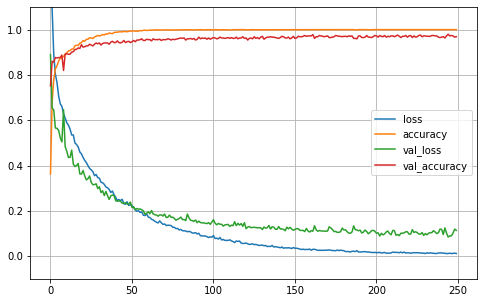

In [28]:
pd.DataFrame(history_inception.history).plot(figsize = (8, 5))
plt.grid(True)
plt.gca().set_ylim(-0.1, 1.1)
plt.savefig("Results/Inception_Attention_Graph.png")
plt.show()